#### Processing 20210212-mneonzld-eveBAC-em2-zsmv-5


In [1]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import czifile
%matplotlib inline

# Import my packages.
import sys
sys.path.append('/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin')
import imagep as imp
reload(imp)
from imagep import viewer, save_pickle, load_pickle, box_spots, read_czi

### 1. Read in czi files

In [2]:
# Read in czi file.
nucchannel = 0
spotchannel = 1

stack1 = read_czi('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/Dots_coming_on/20210212-mneonzld-eveBAC-em2-zsmv-05.czi', True)



mv_filename = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/20210212-mneonzld-eveBAC-em2-zsmv-05.pkl'

In [3]:
viewer(stack1)

interactive(children=(Dropdown(description='Color', index=7, options=('Gators', 'Reds', 'magma', 'plasma', 'in…

### 2. Concatenate stacks

In [4]:
stack, frames = imp.concatenate_5dstacks([stack1])
viewer(stack, zmax=True)

interactive(children=(Dropdown(description='Color', index=7, options=('Gators', 'Reds', 'magma', 'plasma', 'in…

### 3. Determine Z adjustments (if unknown)

In [ ]:
print(frames)

In [ ]:
# Set one viewer to one of the frames in frames, the other to the frame before it (n and n-1).
# For each junction, supply the number that must be added to the *later* frame to match positions to the earlier frame.
viewer(stack[nucchannel, 13])
viewer(stack[nucchannel, 14])

In [5]:
z_corrs = []

### 4. Determine parameters for segmentation of nuclei.

In [6]:
reload(imp)
# Perform test initial segmentation of nuclei.
seed_window = (75,75)
size_max = 6000
size_min=300
circularity_min = 0
nucmask_test = imp.segment_nuclei_4dstack(stack[nucchannel,0:5], imp.segment_nuclei3D_monolayer_rpb1, seed_window=seed_window, size_min=size_min, size_max=size_max, circularity_min=circularity_min)

1 2 3 4 


#### Optional: view initial segmentation and ensure it is reasonable

In [7]:
viewer(nucmask_test, figsize=12)

interactive(children=(Dropdown(description='Color', index=7, options=('Gators', 'Reds', 'magma', 'plasma', 'in…

### 5. Perform initial segmentation and connect nuclei

In [8]:
nucmask_init = imp.segment_nuclei_4dstack(stack[nucchannel], imp.segment_nuclei3D_monolayer_rpb1, seed_window=seed_window, size_min=size_min, size_max=size_max, circularity_min=circularity_min)
nucmask_conn = imp.connect_nuclei(nucmask_init)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 


#### Optional: view connected segmentation

In [9]:
viewer(nucmask_conn, figsize=12)

interactive(children=(Dropdown(description='Color', index=7, options=('Gators', 'Reds', 'magma', 'plasma', 'in…

### 6. Interpolate to fill in gaps

In [10]:
#nucmask = imp.interpolate_nuclear_mask(nucmask_conn, 3)
nucmask = nucmask_conn

#### View final nuclear segmentation

In [ ]:
viewer(nucmask, figsize=12)

### 7. Perform gaussian fitting on MS2 channel

In [11]:
min_distances = (16, 40, 40)
fitwindow_rad_xy = 10
fitwindow_rad_z = 2
sigma_small = 1

fits = imp.fit_ms2(stack[spotchannel], min_distances=min_distances, fitwindow_rad_xy=fitwindow_rad_xy, sigma_small=sigma_small)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 

### 8. Filter fits

In [12]:
# Parameters for filtering fit
reload(imp)
peakiness = 4.5
fits_filtered = imp.filter_ms2fits(fits, peakiness, stack, spotchannel)
imp.quickview_ms2(stack, fits_filtered, 1)

/Users/michaelstadler/Bioinformatics/Projects/rpb1/bin/imagep.py:2206: RuntimeWarning: divide by zero encountered in log
  spot_peakiness = np.log(peak_heights / xy_width_means)


interactive(children=(Dropdown(description='Color', index=10, options=('Gators', 'Reds', 'magma', 'plasma', 'i…

### 9. Connect spots from fits

__*Run on a subset of the data to tweak parameters*__

In [13]:
max_frame_gap = 1
max_jump = 18
scale_xy = 1
scale_z = 1

# Test on first n frames.
n = 6
min_len = 3

test_spots_connected = imp.connect_ms2_fits_focuscorrect(fits_filtered[0:n], [0], [0], nucmask, 
    max_frame_gap=max_frame_gap, max_jump=max_jump, scale_xy=scale_xy, scale_z=scale_z)

test_spots_connected = imp.filter_spot_duration(test_spots_connected, min_len)

imp.quickview_ms2(stack, test_spots_connected, spotchannel)

1 2 3 4 5 

interactive(children=(Dropdown(description='Color', index=10, options=('Gators', 'Reds', 'magma', 'plasma', 'i…

__*Run on the full dataset with selected parameters*__

In [14]:
# Connect all frames.
spots_connected = imp.connect_ms2_fits_focuscorrect(fits_filtered, [0], [0], nucmask, 
    max_frame_gap=max_frame_gap, max_jump=max_jump, scale_xy=scale_xy, scale_z=scale_z)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 

In [15]:
min_len = 5

# Filter for trajectory length.
spot_data = imp.filter_spot_duration(spots_connected, min_len)

In [16]:
# Check the results.
imp.quickview_ms2(stack, spot_data, channel = spotchannel, MAX=True)

interactive(children=(Dropdown(description='Color', index=10, options=('Gators', 'Reds', 'magma', 'plasma', 'i…

### 10. Add integrations of data around spots
__*Integrated volume of MS2 signal: finds mean signal (in un-processed data) of an ellipsoid centered at the spot center*__

In [17]:
ij_rad = 6
z_rad = 1.1
ij_scale = 1
z_scale = 1

spot_data2 = imp.add_volume_mean(spot_data, stack, spotchannel, ij_rad, z_rad, ij_scale, z_scale)

10 20 30 40 50 

__*Integrated gaussian fit: integrates the 'area under the curve'&ast; of the gaussian fit*__

*obviously, generalized from 1 to 3 dimensions

In [18]:
wlength_ij = 13
wlength_z = 3
reload(imp)
spot_data3 = imp.add_gaussian_integration(spot_data2, wlength_ij, wlength_z)

__*Integrated volume of protein signal: finds mean signal (in un-processed data) of an ellipsoid centered at the spot center*__

In [19]:
spot_data4 = imp.add_volume_mean(spot_data3, stack, nucchannel, ij_rad, z_rad, ij_scale, z_scale)

10 20 30 40 50 

### 11. Package into *movie* object and save.

In [20]:
mv = imp.movie(stack, nucmask, fits, spot_data4)
save_pickle(mv, mv_filename)

### 12. Do some QC on tracking.

[ 5  5  5  5  5  5  5  5  6  6  6  6  7  7  7  7  8  8  9  9 10 10 10 11
 11 11 12 13 13 14 14 15 16 16 16 17 18 20 20 21 22 24 25 28 29 31 32 33
 33 33 35 41 42 44]


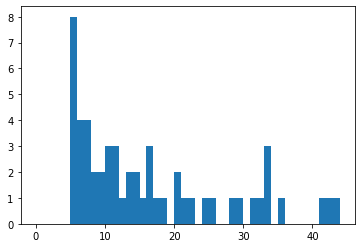

In [21]:
# Look at trajectory lengths.
lens = np.sort(np.count_nonzero(~np.isnan(mv.intvol), axis=0))
plt.hist(lens, bins = np.arange(0,len(mv.intvol)+1));
print(lens)

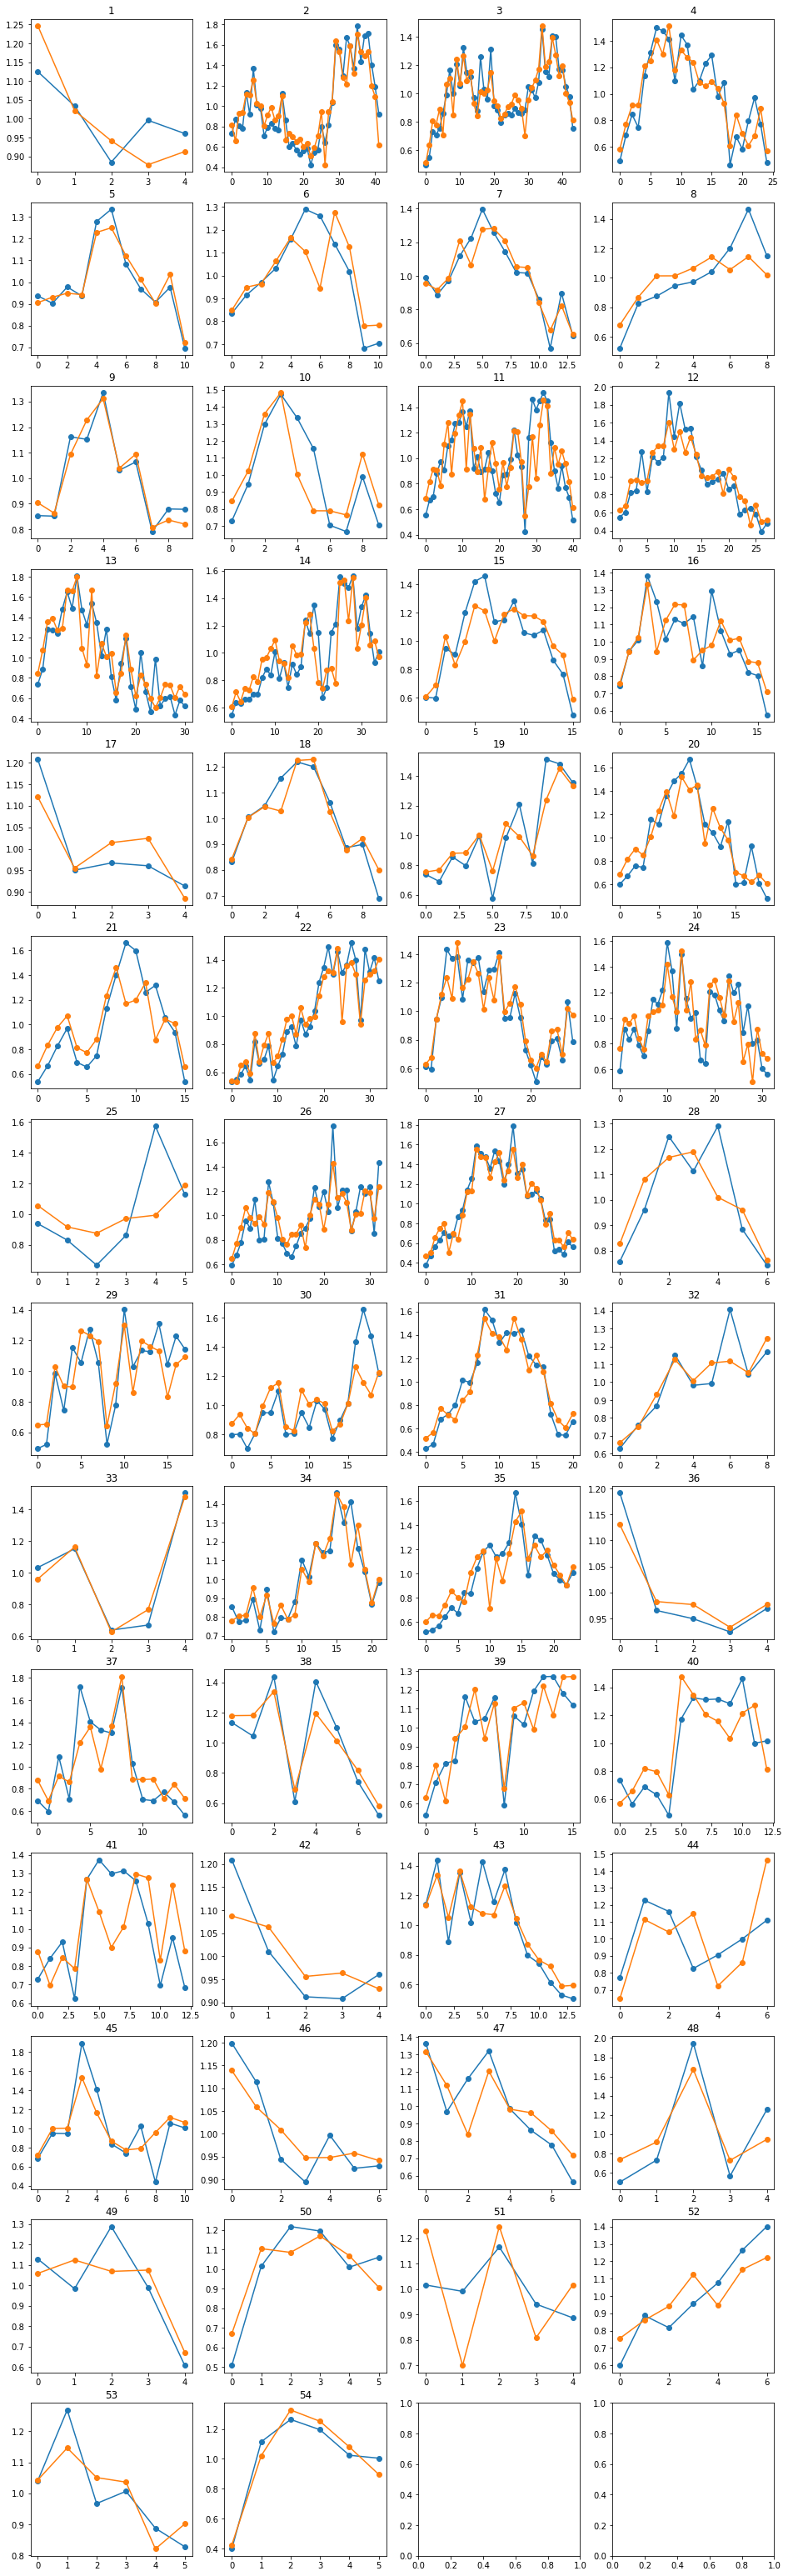

In [22]:
# Plot integrated volumes and gaussian fits together.
num_to_plot=len(mv.spot_data)
def test(x):
    plt.plot(mv.spot_data[x][:,9] / np.mean(mv.spot_data[x][:,9]), marker="o") # volume integration in blue.
    plt.plot(mv.spot_data[x][:,10] / np.mean(mv.spot_data[x][:,10]),marker="o") # gaussian integration in orange.
    plt.title(x)
imp.plot_ps(test, range(1,num_to_plot+1))

<ipython-input-23-acbc71bdf7d9>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,2)


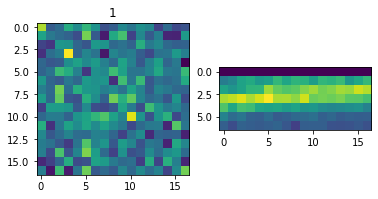

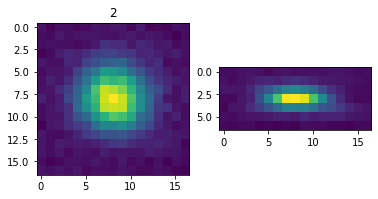

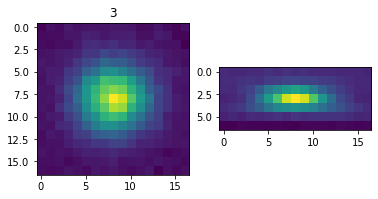

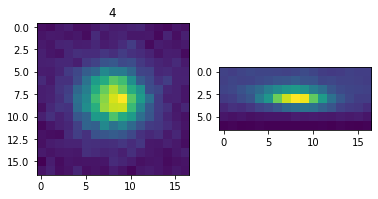

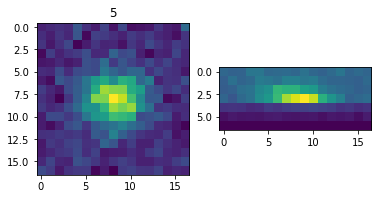

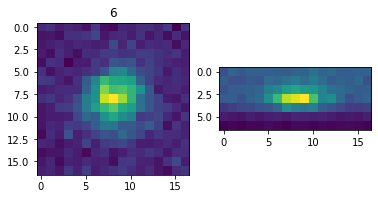

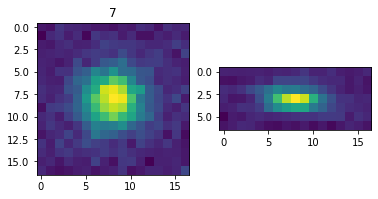

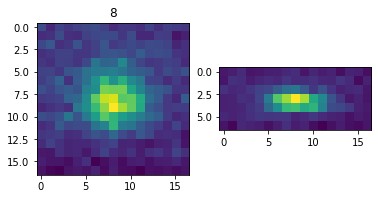

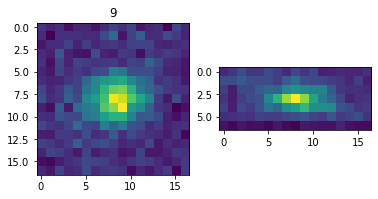

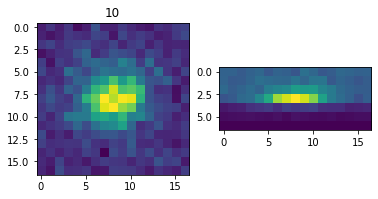

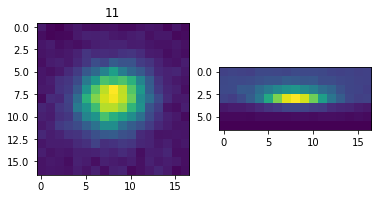

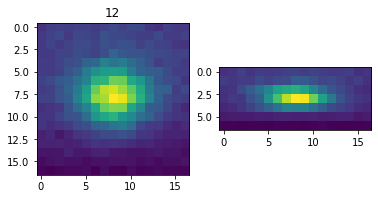

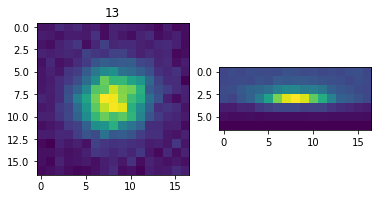

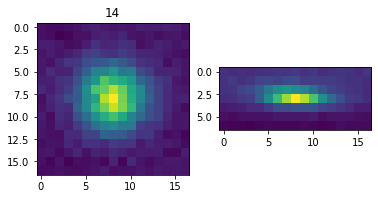

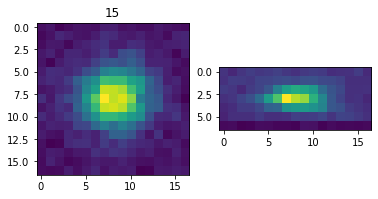

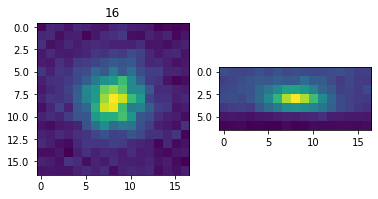

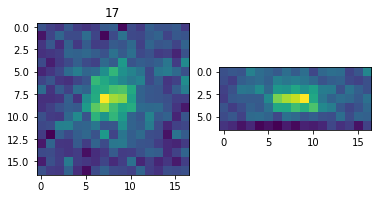

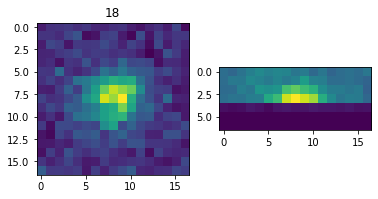

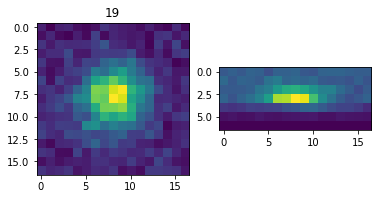

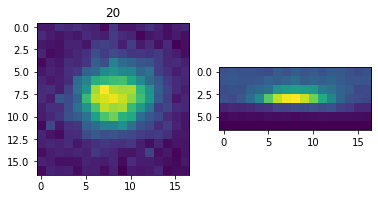

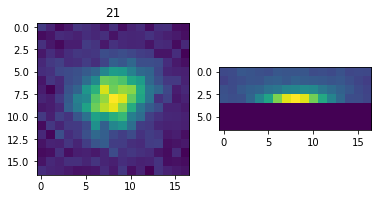

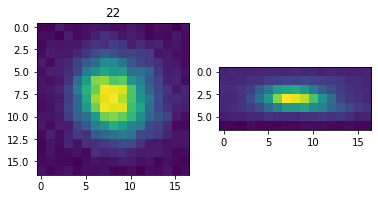

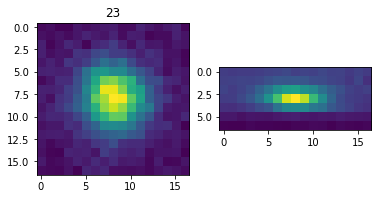

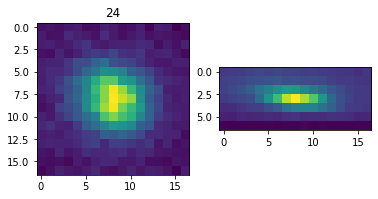

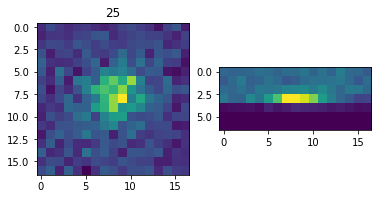

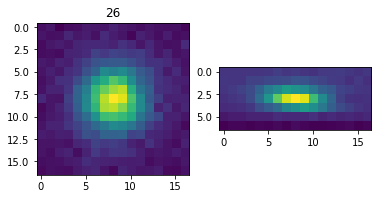

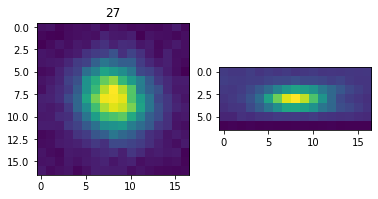

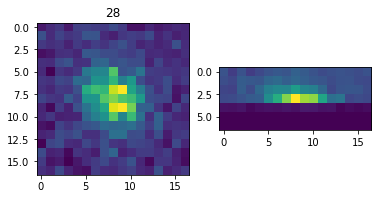

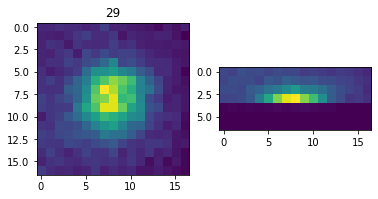

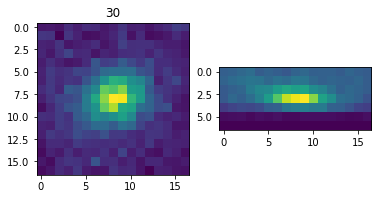

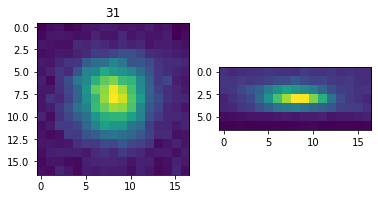

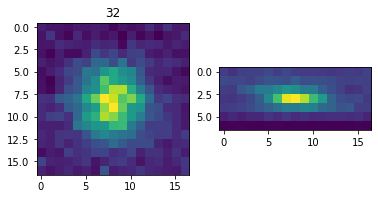

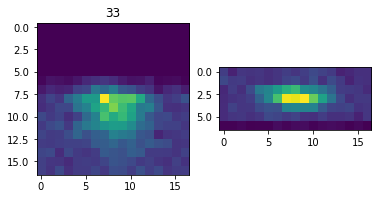

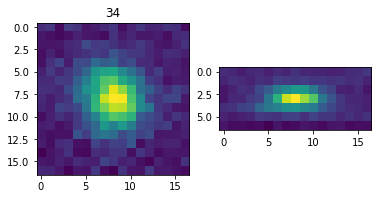

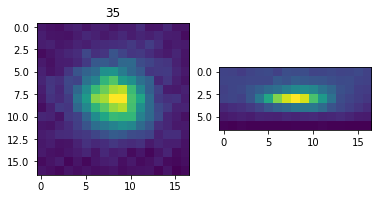

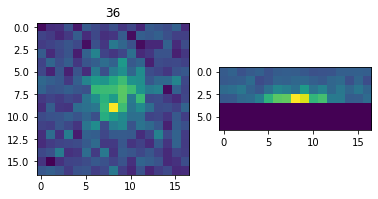

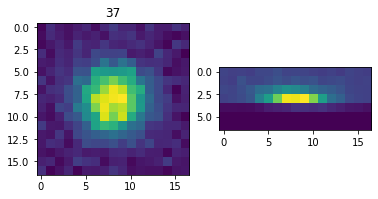

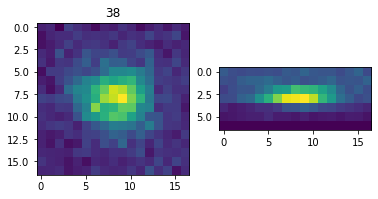

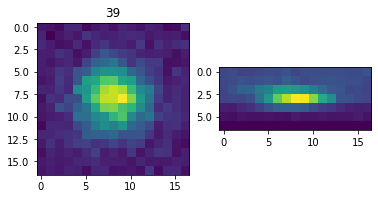

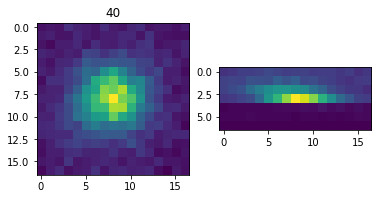

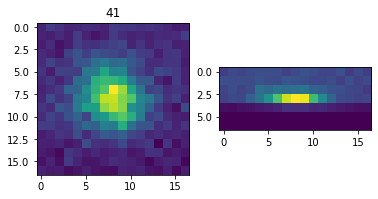

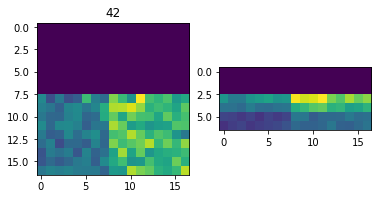

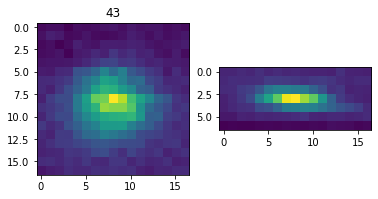

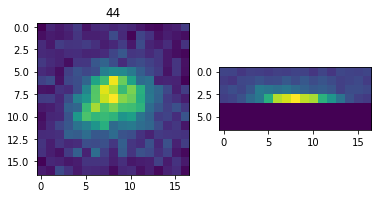

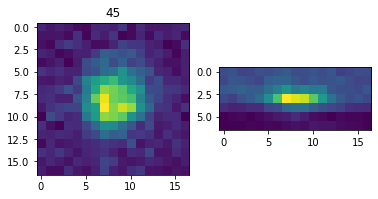

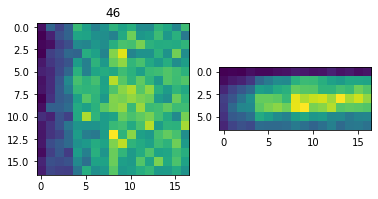

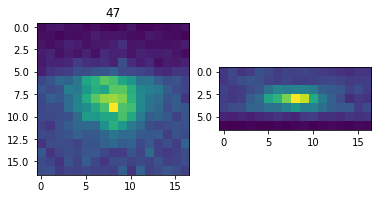

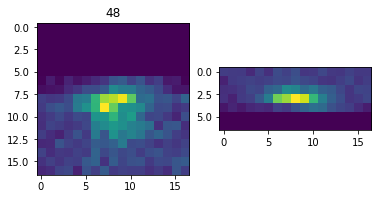

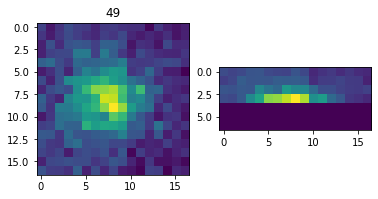

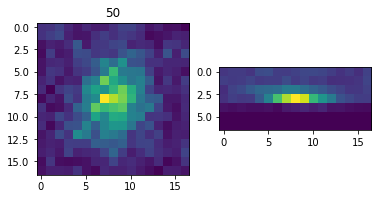

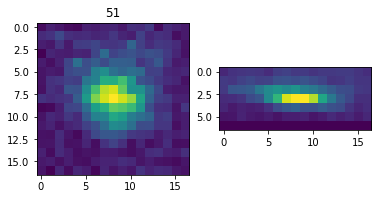

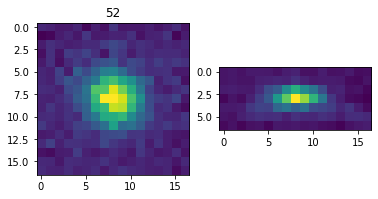

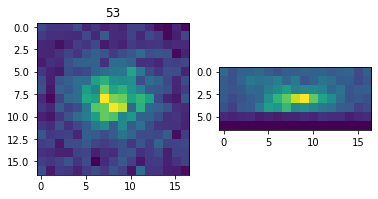

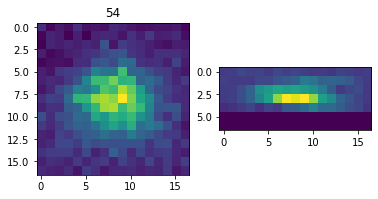

In [23]:
# Examine time-averaged xy (Z-projection) and xz views of each spot.
sm = imp.spot_movies(mv.stack, mv.spot_data, 1,17, fill=0, view=False)

for x in range(1,len(sm)):
    xy = sm[x].mean(axis=(0,1))
    xz = sm[x].mean(axis=(0,2))
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(xy)
    ax[0].set_title(x)
    ax[1].imshow(xz)


In [ ]:
# Examine individual spots in original data.
spot_to_view = 1
imp.quickview_ms2(mv.stack, mv.spot_data, 1, spot_to_view, MAX=True)

In [ ]:
stack.shape